## Project 5
# Vehicle Detection and Tracking
#### Most of the code in this project have been adapted from quizes done in the lesson


In [6]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from helperFunctions import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
import time
from sklearn import tree
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from moviepy.editor import VideoFileClip

% matplotlib inline

### Read in the dataset and display a sample

In [241]:
# Read in the dataset
car_images = glob.glob('./Dataset/Large/vehicles/vehicles/*/*.png')
noncar_images1 = glob.glob('./Dataset/Large/non-vehicles/non-vehicles/Extras/*.png')
noncar_images2 = glob.glob('./Dataset/Large/non-vehicles/non-vehicles/more/*.png')

noncar_images = np.hstack((noncar_images1,noncar_images2,noncar_images2))

In [242]:
# Print lengths of the image Datasets
print('Number of car images: ',len(car_images))
print('Number of non-car images: ',len(noncar_images))


Number of car images:  8792
Number of non-car images:  13078


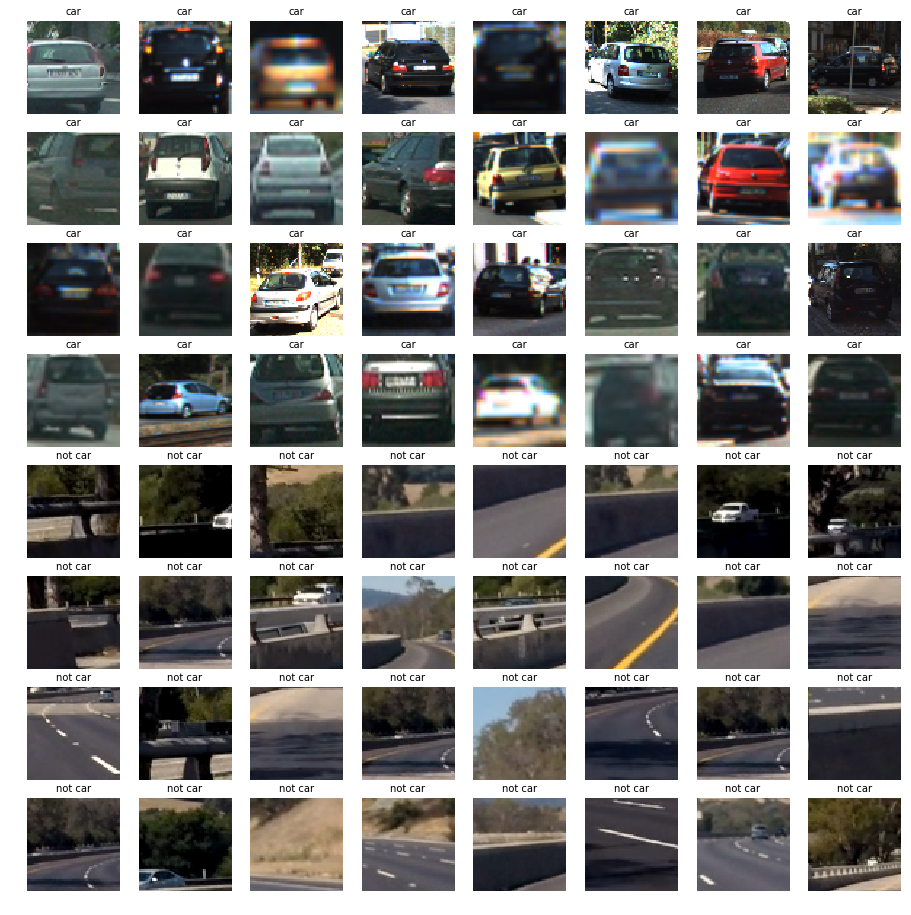

In [243]:
# Display some images from the datasets
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()


for i in np.arange(32):
    img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)

    

### Define functions that extract features from images

In [244]:
# Function to return raw pixel values as features

# This function is NOT used in feature extraction later in the project.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    """
    FUNCTION TO PASS RAW PIXELS AS FEATURES

    Converts the colorspace if not RGB,
    reduce the image size to given size, 
    pass the reduced image as vector.
   """
   # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [245]:
# Write function to return Color Histogram as features
def color_hist(image, nbins=32, bins_range=(0, 256)):

    
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

In [246]:
# Write function that returns Hog features of the image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Returns Hog feature vector.
    Parameters are: Orientations bins, Pixels per cell and Cells per block
    """
    # Call with two outputs if vis==True
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block), 
                                transform_sqrt=False, 
                                visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Visualize HOG features

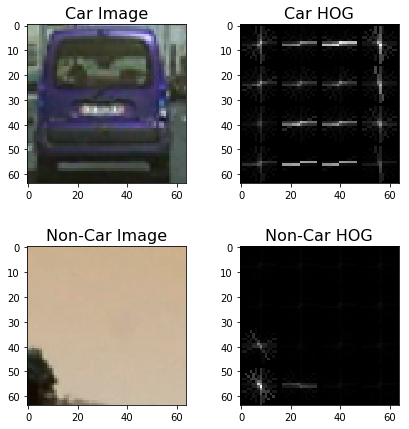

In [247]:
# Visualize hog features on two test images
orient = 11
pix_per_cell = 16
cell_per_block = 2
car_image = cv2.imread(car_images[np.random.randint(0,len(car_images))])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
noncar_image = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2GRAY)
_,car_hog = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_hog = get_hog_features(noncar_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_image)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Generate dataset features, normalize them and train the classifier.

In [248]:
# Combined feature extraction
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                                orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel = 'ALL', vis=False, feature_vec=True):
    """
    Function to get features of images in the dataset for training our classifier
    """
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate(( hist_features,hog_features)))
        #features.append(hist_features, hog_features)
    # Return list of feature vectors
    return features


In [249]:
t=time.time()
car_features = extract_features(car_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,hog_channel = 'ALL', vis=False, feature_vec=True)
notcar_features = extract_features(noncar_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,hog_channel = 'ALL', vis=False, feature_vec=True)
t2 = time.time()
print('Took', round(t2-t, 5), 'Seconds to extract features')


Took 62.77435 Seconds to extract features


In [250]:
print('Feature vector length: ', len(car_features[0]))

Feature vector length:  1284


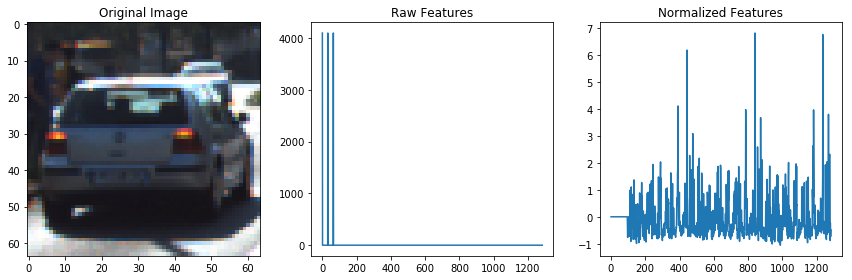

1284


In [251]:
# Normalize combined features, and visualize one sample
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_images))
    #Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
    print(len(car_features[0]))
    

In [252]:
# Training the Classifier:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Took', round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Took 5.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  1.  0.  1.  1.]
0.00194 Seconds to predict 10 labels with SVC


In [253]:
# Generate templates from image for classification
def generate_templates(img, x_overlap = 0.5, y_overlap = 0.7, max_size = 150, min_size = 32):
    """
    Function to generate templates with size varying with 'Y' 
    NOT USED
    """
    image = np.copy(img)
    h,w = image[:,:,-1].shape
    # y_start and y_stop are limits that define which parts of the image is to be searched.
    y_stop = h//3; y_start = h-50;
    size = max_size # Set the initial template size to max size
    template_per_y = np.int((w/(max_size*(1 - x_overlap)))) # Number of templates at each y is same.
    x_start = 0; # Templates start with an x offset that is initially zero
    y_leftbottom = 0.0; x_leftbottom = 0; # y_leftbottom starts with zero and goes upto y_max. It is later transformed into image coordinates.
    templates = [] # Create an empty list to save the templates
    while y_leftbottom < y_stop :
        for i in range(template_per_y):
            x_leftbottom = x_start + (i*size*(1-x_overlap))
            x_topright = x_leftbottom + size            
            startx = np.int(x_leftbottom)
            starty = np.int(y_start - y_leftbottom)
            endx = np.int(x_topright)
            endy = np.int(starty - size)
            templates.append(((startx, starty), (endx, endy)))
        y_leftbottom += np.int((1-y_overlap)*size) # shift y for next row
        x_start += w//25 # Update x offset
        size = max_size - y_leftbottom*((max_size - min_size)/y_stop) # Update template size(linear equation is used)
        x_overlap = 0.5*(1 - y_leftbottom/y_stop) # x_overlap decreases with y
    return templates

In [254]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


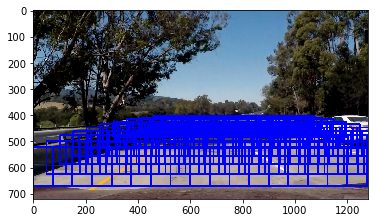

In [255]:
# Visualize the generated templates
testimage = mpimg.imread('./testimages/testImage1.jpg')

templates = generate_templates(testimage)
box_img = draw_boxes(testimage, templates)
plt.imshow(box_img)
plt.show()


### Define functions to detect cars in the video frames

In [256]:
def find_cars(ip_img,svc, X_scaler, ystart = 400, ystop = 650, scale=1.5,  orient = 9, pix_per_cell = 8 , cell_per_block = 2, spatial_size = (32,32), hist_bins = 32):
    """
    Function to detect cars in the image by only finding HOG features once.
    """
    
    draw_img = np.copy(ip_img)
    #img = img.astype(np.float32)/255
    
    boxes = []
    img_tosearch = ip_img[ystart:ystop,:,:]
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            
            test_features = X_scaler.transform(np.hstack(( hist_features, hog_features)).reshape(1, -1))
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            svc_prediction = svc.predict(test_features)
            #bdt_prediction = bdt.predict(test_features)
            
            if (svc_prediction==1) :
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) )
                
    return boxes

In [257]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function to draw given boxes on the given image
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

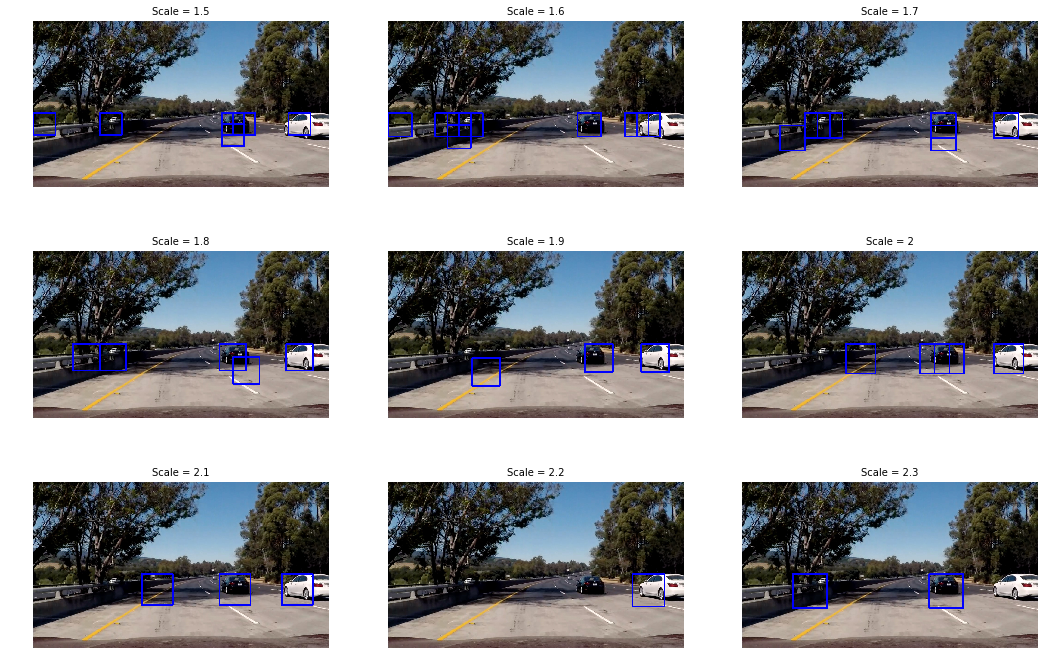

In [258]:
# Draw boxes detected with various scales

fig, axs = plt.subplots(3,3, figsize=(18,12))
#fig.subplots_adjust(hspace = 0.25, wspace = 0.35)
axs = axs.ravel()
scales = [1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3]


for i in np.arange(len(scales)):
    boxes = find_cars(testimage,svc, X_scaler,scale = scales[i],orient = 11, pix_per_cell = 16)
    axs[i].axis('off')
    axs[i].set_title('Scale = {}'.format(scales[i]), fontsize=10)
    axs[i].imshow(draw_boxes(testimage, boxes))
#plt.imshow(draw_boxes(testimage, boxes))

In [259]:
# Define function to gain confidence in the detections and ignore false positives

def addheat(shape, bboxes):
    allblack = np.zeros(shape)
    #for ((x1,y1),(x2,y2)) in bboxes:
    for box in bboxes:
        
        allblack[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return(allblack)

def apply_threshold(heat, threshold = 1 ):
    heat[heat < threshold] = 0
    return heat

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

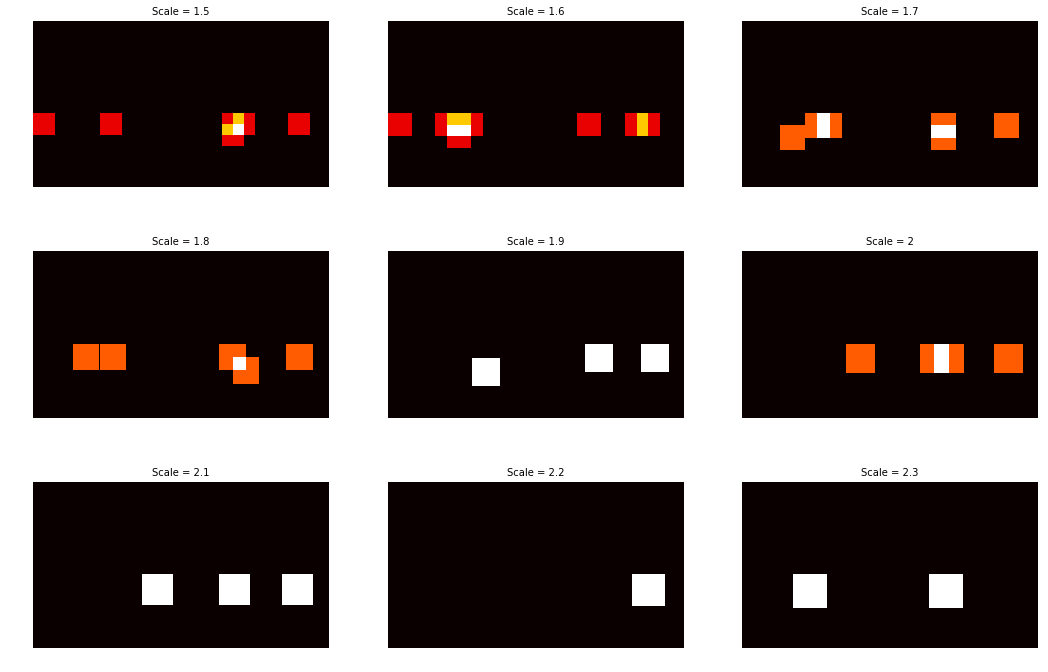

In [260]:
# Display heat of bolocks with different scales

fig, axs = plt.subplots(3,3, figsize=(18,12))
#fig.subplots_adjust(hspace = 0.25, wspace = 0.35)
axs = axs.ravel()
scales = [1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3]

for i in np.arange(len(scales)):
    boxes = find_cars(testimage,svc, X_scaler,scale = scales[i],orient = 11, pix_per_cell = 16)
    heat = addheat(testimage[:,:,0].shape, boxes)
    axs[i].axis('off')
    axs[i].set_title('Scale = {}'.format(scales[i]), fontsize=10)
    axs[i].imshow(heat, cmap='hot')

In [261]:

def find_cars_in_frame(testimage):
    """
    Function to search every frame using multiple scales.
    Returns image with boxes drawn on the detections.
    """
    rectangles = []
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 1.5,orient = 11, pix_per_cell = 16)
    for box in bboxes:
        rectangles.append(box)
        
    bboxes = find_cars(testimage,svc, X_scaler,scale = 1.6,orient = 11, pix_per_cell = 16)   
    for box in bboxes:
        rectangles.append(box)
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 1.7,orient = 11, pix_per_cell = 16)    
    for box in bboxes:
        rectangles.append(box)
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 1.8,orient = 11, pix_per_cell = 16)        
    for box in bboxes:
        rectangles.append(box)
        
    bboxes = find_cars(testimage,svc, X_scaler,scale = 1.9,orient = 11, pix_per_cell = 16)    
    for box in bboxes:
        rectangles.append(box)
        
    bboxes = find_cars(testimage,svc, X_scaler,scale = 2,orient = 11, pix_per_cell = 16)       
    for box in bboxes:
        rectangles.append(box)
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 2.1,orient = 11, pix_per_cell = 16)       
    for box in bboxes:
        rectangles.append(box)
        
    bboxes = find_cars(testimage,svc, X_scaler,scale = 2.2,orient = 11, pix_per_cell = 16)       
    for box in bboxes:
        rectangles.append(box)
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 2.3,orient = 11, pix_per_cell = 16)       
    for box in bboxes:
        rectangles.append(box)
    
    bboxes = find_cars(testimage,svc, X_scaler,scale = 2.4,orient = 11, pix_per_cell = 16)       
    for box in bboxes:
        rectangles.append(box)
        
    heat = addheat(testimage[:,:,0].shape, rectangles)    
    heat = apply_threshold(heat, threshold = 7)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(testimage), labels)
    
    return draw_img

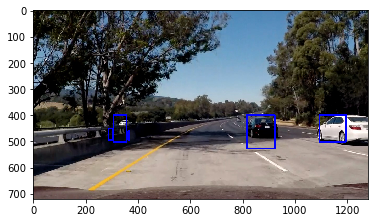

In [262]:
plt.imshow(find_cars_in_frame(mpimg.imread('./testimages/testImage1.jpg')))

### Test pipeline on some more images

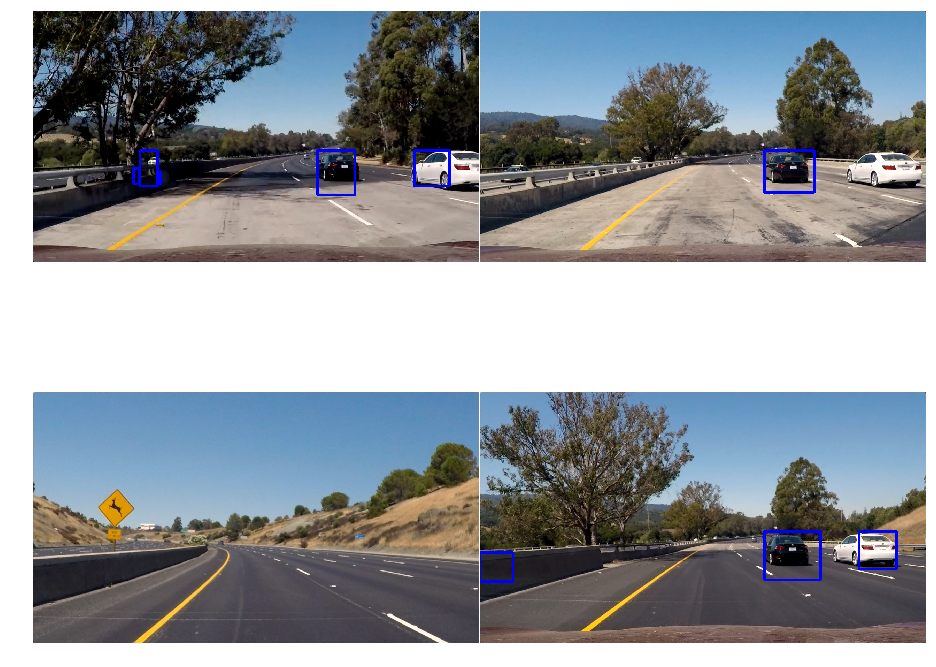

In [263]:
test_images = glob.glob('./testimages/*')

fig, axs = plt.subplots(2, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    
    axs[i].imshow(find_cars_in_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Apply the pipeline on the project video

In [264]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(find_cars_in_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [14:05<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 10min 13s, sys: 1min 54s, total: 1h 12min 8s
Wall time: 14min 6s
